# Run a batch of samples on the HPC cluster

This experiment is part of a series which should help us validate the Kingston, ON model.

## Set-up orchistration and compute environments

To set-up access to the remote compute server:

1. On the local host generate keys:

```
ssh-keygen -t rsa
```

1. Copy those keys to the remote host:

```
cat ~/.ssh/id_rsa.pub | ssh user@hostname 'cat >> .ssh/authorized_keys'
```

In [ ]:
!cat /src/ansible/playbooks/hosts

### Install simulator on compute environments

In [ ]:
!ansible-playbook -i /src/ansible/playbooks/hosts /src/ansible/playbooks/covid19sim.yml --extra-vars 'host=mulab' --user=paredes

### Copy Kingston configuration file to compute environments

In [ ]:
!ansible -i /src/ansible/playbooks/hosts mulab --user=paredes -m copy -a "src=params/kingston_0xdfc056a4fdb804e60e964b2cc5aae6ea.yml dest=~/COVI-AgentSim/src/covid19sim/configs/simulation/region/kingston0xdfc056a4fdb804e60e964b2cc5aae6ea.yaml"

### Generate random seeds

In [ ]:
!/opt/conda/bin/conda run -n covisim conda install numpy -y

In [ ]:
cpus = 16
compute = 16
n_samples = cpus * compute
n_samples

In [ ]:
import numpy as np
from numpy.random import default_rng
import pandas as pd

rng = default_rng()

seed_list = [rng.integers(low=0, high=1e4) for _ in range(n_samples)]

len(np.unique(seed_list)), pd.DataFrame(seed_list).hist()

### Build run commands

In [ ]:
args_dict = {'region': 'kingston0xdfc056a4fdb804e60e964b2cc5aae6ea',
        'n_people': 3000,
        'simulation_days': 60,
        'init_fraction_sick': 0.002,
        'N_BEHAVIOR_LEVELS': 2,
        'intervention': 'no_intervention',
        'tune': True,
        'track': 'light',
        'GLOBAL_MOBILITY_SCALING_FACTOR': 0.85,
        'APP_UPTAKE': -1,
        'USE_INFERENCE_SERVER': False,
        'INTERVENTION_DAY': -1}
args_dict

In [ ]:
args_str = ' '.join([f'{k}={v}' for k, v in args_dict.items()])
args_str

In [ ]:
import random
import subprocess

run_id = hex(random.getrandbits(128))

args_list = [f'~/.conda/envs/covisim/bin/python ~/COVI-AgentSim/src/covid19sim/run.py seed={s} outdir=~/kingston-abm/experiments/validation/results/data/{run_id} {args_str}\n' for s in seed_list]

file_name = f'val-2-{run_id}.cmd'

with open(file_name, 'w') as arg_file:
    arg_file.writelines(args_list)
    
#subprocess.run(f'cat {file_name} | parallel -j4, shell=True, capture_output=True)

file_name

## Run simulations

In [ ]:
!cat val-2-0x57e7aa91fbc783d1f3cd1bf719dd5a35.cmd | parallel --sshloginfile nodefile

## Set up the local analysis environment

In [4]:
!ansible-playbook -i /src/ansible/playbooks/hosts /src/ansible/playbooks/covid19sim.yml


PLAY [Set-up covid19sim] *******************************************************

TASK [Gathering Facts] *********************************************************
ok: [localhost]

TASK [Create a new viritual environment] ***************************************
changed: [localhost]

TASK [Clone ctt module, required to run simulator] *****************************
changed: [localhost]

TASK [Use fixed requirements.txt] **********************************************
changed: [localhost]

TASK [Use fixed setup.py] ******************************************************
changed: [localhost]

TASK [Version of ctt module should be commit hash] *****************************
changed: [localhost]

TASK [Install ctt module] ******************************************************
changed: [localhost]

TASK [Checkout a viable commit] ************************************************
changed: [localhost]

TASK [Version of covid19sim module should be commit hash] **********************
changed: [localho

In [ ]:
!ipython kernel install --name covisim

In [ ]:
!/opt/conda/bin/conda run -n covisim conda install ipykernel -y

In [8]:
!/opt/conda/bin/conda run -n covisim conda install matplotlib -y

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda/envs/covisim

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    cycler-0.10.0              |           py38_0          14 KB
    intel-openmp-2021.2.0      |     h06a4308_610         1.3 MB
    kiwisolver-1.3.1           |   py38h2531618_0          80 KB
    lcms2-2.12                 |       h3be6417_0         312 KB
    libtiff-4.2.0              |       h85742a9_0         502 KB
    libwebp-base-1.2.0         |       h27cfd23_0         437 KB
    libxml2-2.9.12             |       h03d6c58_0         1.2 MB
    lz4-c-1.9.3                |       h2531618_0         186 KB
    matplotlib-3.3.4           |   py38h06a4308_0          26 KB
    matplotlib-base-3.3.4      |   py38h62a2d02_0   

In [23]:
import os

run_id = '0x57e7aa91fbc783d1f3cd1bf719dd5a35'

samples = os.listdir(f'../data/{run_id}')
len(samples)

256

In [36]:
import pandas as pd

data = [os.listdir(f'../data/{run_id}/{s}') for s in samples]

data_df = pd.DataFrame(data, columns=['params', 'log', 'metrics'])
data_df['sample'] = samples
data_df.head()

,params,log,metrics,sample
0,full_configuration.yaml,log_20210706-135347.txt,tracker_data_n_3000_seed_1054_20210706-140112.pkl,sim_v2_people-3000_days-60_init-0.002_uptake--...
1,full_configuration.yaml,log_20210706-140134.txt,tracker_data_n_3000_seed_1061_20210706-140858.pkl,sim_v2_people-3000_days-60_init-0.002_uptake--...
2,full_configuration.yaml,log_20210706-135348.txt,tracker_data_n_3000_seed_1106_20210706-140058.pkl,sim_v2_people-3000_days-60_init-0.002_uptake--...
3,full_configuration.yaml,log_20210706-140136.txt,tracker_data_n_3000_seed_1182_20210706-141003.pkl,sim_v2_people-3000_days-60_init-0.002_uptake--...
4,full_configuration.yaml,log_20210706-135349.txt,tracker_data_n_3000_seed_1199_20210706-140153.pkl,sim_v2_people-3000_days-60_init-0.002_uptake--...


In [37]:
import pickle

cases_list = []
i=0
for _, data in data_df.iterrows():
    with open(f'/src/experiments/data/{run_id}/{data["sample"]}/{data["metrics"]}', 'rb') as tracker:
        tracker_dict = pickle.load(tracker)
        cases_list.append(pd.DataFrame(tracker_dict['cases_per_day'], columns=[i]))
        i += 1
cases_df = pd.concat(cases_list, axis=1)
cases_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,1,0,...,2,2,1,2,0,1,0,1,6,2
3,1,4,1,1,2,1,0,1,2,1,...,0,7,2,7,2,2,1,1,1,1
4,0,1,6,0,1,5,4,2,5,0,...,6,9,4,3,3,3,0,1,2,1


In [ ]:
!ansible -i /src/ansible/playbooks/hosts mulab --user=paredes -a "ls ~/kingston-abm/experiments/validation/results/data/0x57e7aa91fbc783d1f3cd1bf719dd5a35/"

In [38]:
cases_df.transpose().head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,6,0,0,1,0,2,4,10,0,0,...,4,10,43,30,29,25,28,4,8,31
1,6,0,0,4,1,4,1,9,1,0,...,11,8,45,23,29,32,31,1,6,24
2,6,0,0,1,6,1,8,11,1,1,...,4,3,29,27,30,22,18,6,3,27
3,6,0,0,1,0,4,5,14,1,0,...,7,3,21,28,12,22,9,1,5,10
4,6,0,0,2,1,4,5,14,1,2,...,11,10,28,23,11,22,18,3,3,12


In [13]:
%matplotlib inline

<AxesSubplot:>

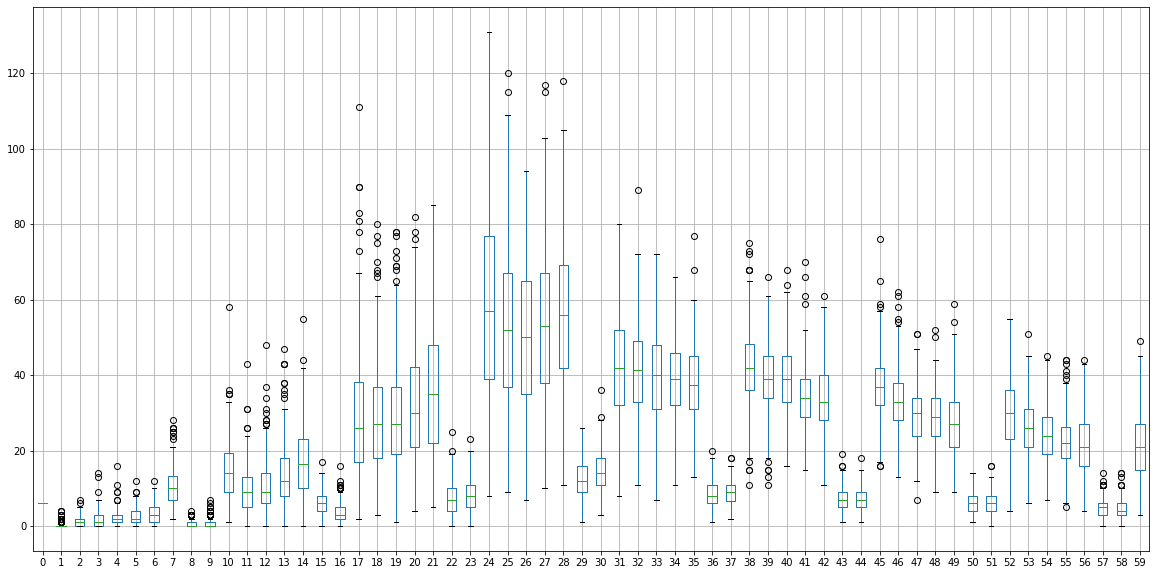

In [14]:
cases_df.transpose().boxplot(figsize=(20,10))

In [28]:
!/opt/conda/bin/conda run -n covisim conda install seaborn -y

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda/envs/covisim

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libgfortran-ng-7.5.0       |      ha8ba4b0_17          22 KB
    libgfortran4-7.5.0         |      ha8ba4b0_17         995 KB
    pandas-1.2.5               |   py38h295c915_0         8.8 MB
    pytz-2021.1                |     pyhd3eb1b0_0         181 KB
    scipy-1.6.2                |   py38had2a1c9_1        15.6 MB
    seaborn-0.11.1             |     pyhd3eb1b0_0         212 KB
    ------------------------------------------------------------
                                           Total:        25.8 MB

The following NEW packages will be INSTALLED:

  libgfortran-ng     pkgs/main/linux-64::libgfortran-ng-7.5.0-ha8ba4b0_17
  libgfortran4       pkgs/main/linux-64::libgfortran4-7.5.0-ha8

### Plot compartment model

In [39]:
import pickle

s_list = []
e_list = []
i_list = []
r_list = []

i=0
for _, data in data_df.iterrows():
    with open(f'/src/experiments/data/{run_id}/{data["sample"]}/{data["metrics"]}', 'rb') as tracker:
        tracker_dict = pickle.load(tracker)
        s_list.append(pd.DataFrame(tracker_dict['s'], columns=[i]))
        e_list.append(pd.DataFrame(tracker_dict['e'], columns=[i]))
        i_list.append(pd.DataFrame(tracker_dict['i'], columns=[i]))
        r_list.append(pd.DataFrame(tracker_dict['r'], columns=[i]))
        i += 1
        
s_df = pd.concat(s_list, axis=1)
e_df = pd.concat(e_list, axis=1)
i_df = pd.concat(i_list, axis=1)
r_df = pd.concat(r_list, axis=1)

s_df.head(), \
e_df.head(), \
i_df.head(), \
r_df.head()

(    0     1     2     3     4     5     6     7     8     9    ...   246  \
 0  2994  2994  2994  2994  2994  2994  2994  2994  2994  2994  ...  2994   
 1  2994  2994  2994  2994  2994  2994  2994  2994  2994  2994  ...  2994   
 2  2994  2994  2994  2994  2994  2994  2994  2994  2994  2994  ...  2993   
 3  2994  2994  2994  2994  2994  2994  2992  2994  2993  2994  ...  2991   
 4  2993  2990  2993  2993  2992  2993  2992  2993  2991  2993  ...  2991   
 
     247   248   249   250   251   252   253   254   255  
 0  2994  2994  2994  2994  2994  2994  2994  2994  2994  
 1  2994  2994  2994  2994  2994  2994  2994  2994  2994  
 2  2992  2994  2994  2994  2994  2994  2994  2994  2994  
 3  2990  2993  2992  2994  2993  2994  2993  2988  2992  
 4  2983  2991  2985  2992  2991  2993  2992  2987  2991  
 
 [5 rows x 256 columns],
    0    1    2    3    4    5    6    7    8    9    ...  246  247  248  249  \
 0    6    6    6    6    6    6    6    6    6    6  ...    6    6    6  

<AxesSubplot:>

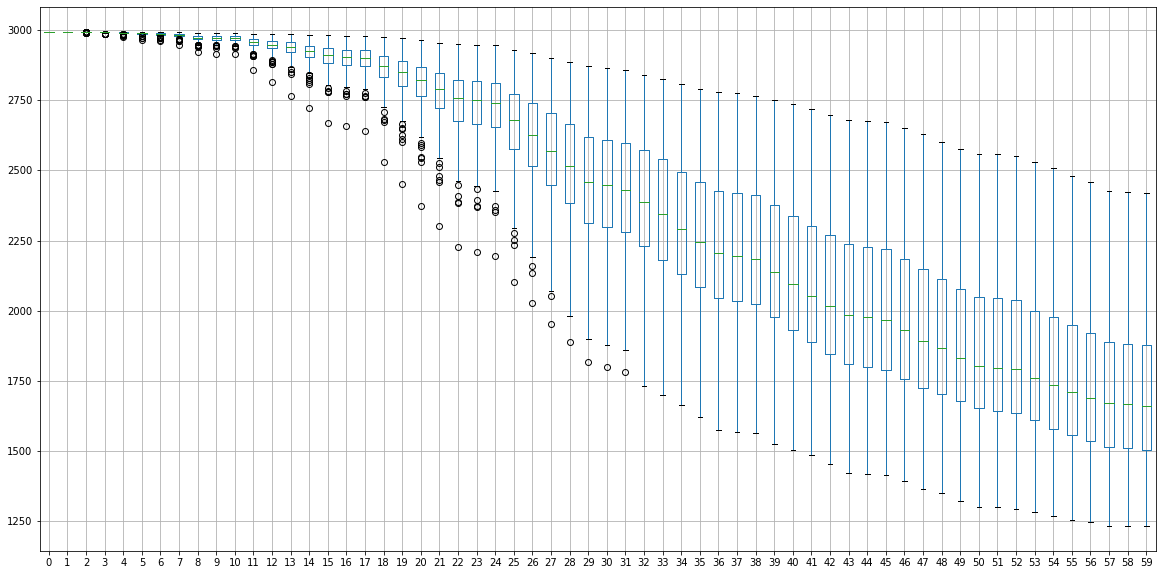

In [69]:
s_df.transpose().boxplot(figsize=(20,10))

<AxesSubplot:>

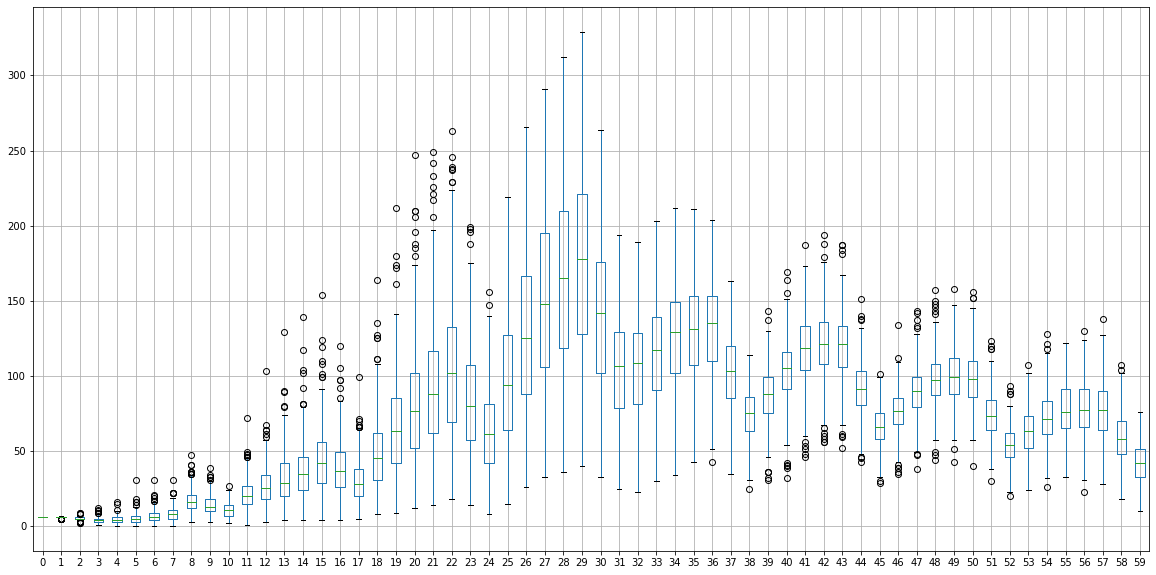

In [70]:
e_df.transpose().boxplot(figsize=(20,10))

<AxesSubplot:>

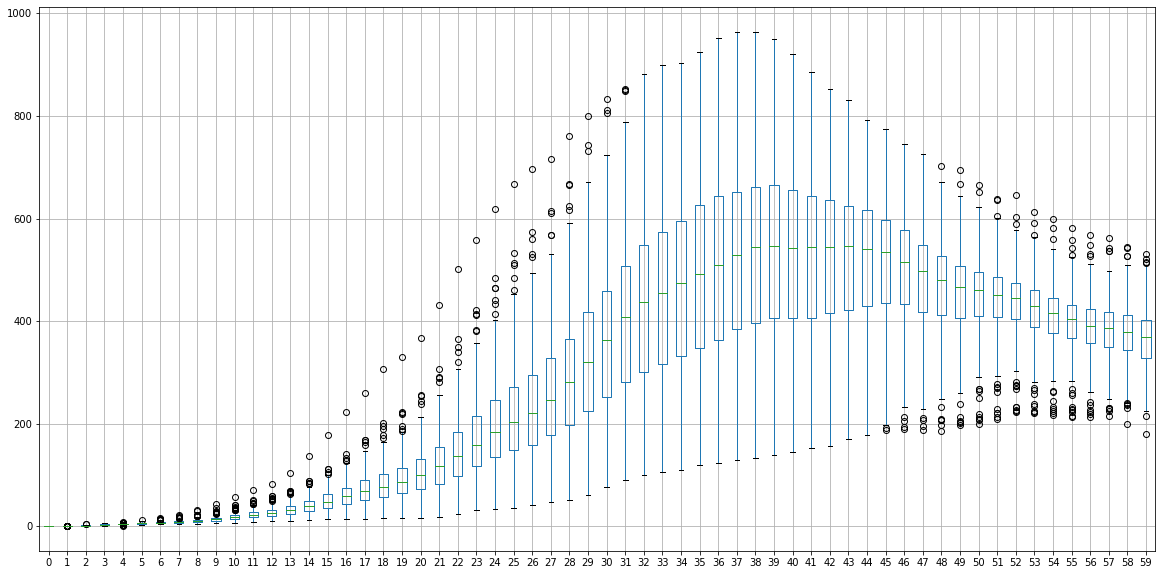

In [71]:
i_df.transpose().boxplot(figsize=(20,10))

<AxesSubplot:>

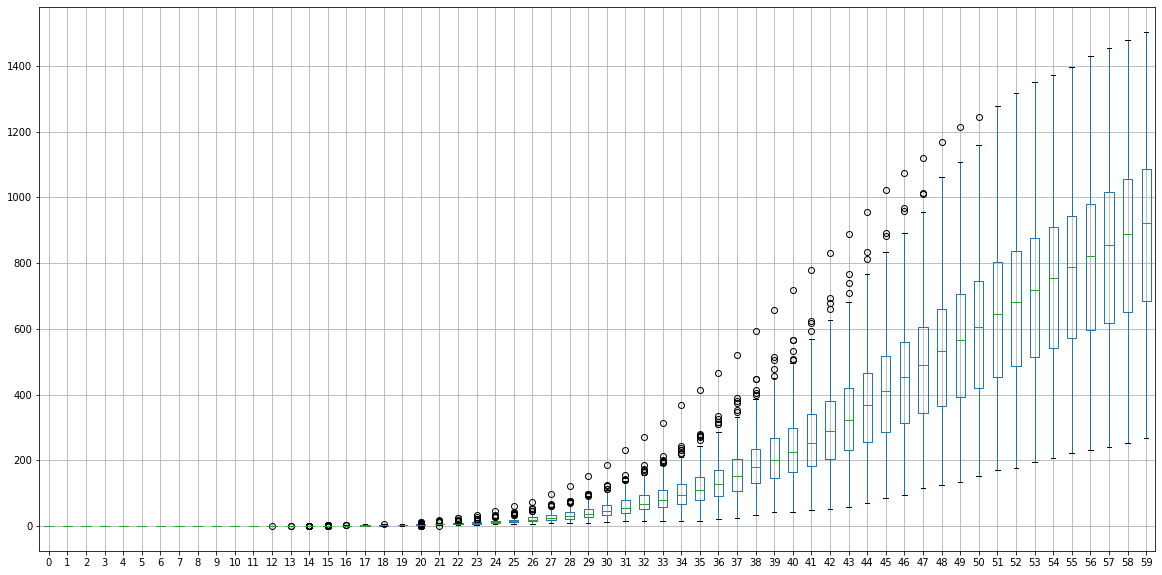

In [72]:
r_df.transpose().boxplot(figsize=(20,10))

In [32]:
s_df['day'] = s_df.index
e_df['day'] = e_df.index
i_df['day'] = i_df.index
r_df['day'] = r_df.index
s_long_df = pd.melt(s_df, id_vars=['day'], value_vars=[i for i in range(256)])
e_long_df = pd.melt(e_df, id_vars=['day'], value_vars=[i for i in range(256)])
i_long_df = pd.melt(i_df, id_vars=['day'], value_vars=[i for i in range(256)])
r_long_df = pd.melt(r_df, id_vars=['day'], value_vars=[i for i in range(256)])
s_long_df['seir'] = 's'
e_long_df['seir'] = 'e'
i_long_df['seir'] = 'i'
r_long_df['seir'] = 'r'
seir_long_df = pd.concat([s_long_df, e_long_df, i_long_df, r_long_df])
seir_long_df.head()

,day,variable,value,seir
0,0,0,2994,s
1,1,0,2994,s
2,2,0,2994,s
3,3,0,2994,s
4,4,0,2993,s


<AxesSubplot:xlabel='day', ylabel='value'>

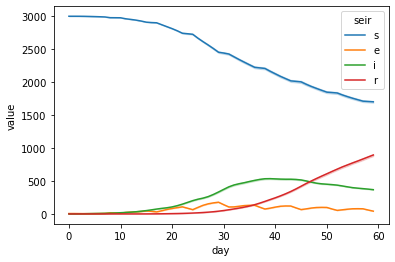

In [34]:
import seaborn as sns

%matplotlib inline

sns.lineplot(data=seir_long_df, 
             x='day', 
             y='value', 
             hue='seir', 
             estimator='mean', 
             ci=68)

## All configuration p

In [18]:
import glob
import os
import yaml

#os.path.abspath('../data/*dd5a35/*seed-1054*')

with open(glob.glob('../data/*dd5a35/*seed-1054*/*.yaml')[0], 'r') as f:
    config = yaml.safe_load(f)

config.keys()

dict_keys(['ADJUSTED_CONTACT_MATRIX_ALL', 'ADJUSTED_CONTACT_MATRIX_HOUSEHOLD', 'ADJUSTED_CONTACT_MATRIX_OTHER', 'ADJUSTED_CONTACT_MATRIX_SCHOOL', 'ADJUSTED_CONTACT_MATRIX_WORKPLACE', 'AGE_AFFECTS_CAREFULNESS', 'AGE_DIFFERENCE_BETWEEN_PARENT_AND_KID', 'AGE_FACTOR_VIRAL_LOAD_HEIGHT', 'ALL_LEVELS_DROPOUT', 'APP_UPTAKE', 'ASSUME_NO_ENVIRONMENTAL_INFECTION_AFTER_INTERVENTION_START', 'ASSUME_NO_UNKNOWN_INTERACTIONS_AFTER_INTERVENTION_START', 'ASSUME_SAFE_HOSPITAL_DAILY_INTERACTIONS_AFTER_INTERVENTION_START', 'ASYMPTOMATIC_INFECTION_RATIO', 'AVERAGE_AGE_REGION', 'AVERAGE_DAYS_DEATH_IF_CRITICAL', 'AVERAGE_DAYS_RECOVERY_IF_CRITICAL', 'AVERAGE_DAYS_RECOVERY_IF_HOSPITALIZED', 'AVERAGE_DAYS_TO_CRITICAL_IF_HOSPITALIZED', 'AVERAGE_DAYS_TO_HOSPITAL_GIVEN_SYMPTOMS', 'AVERAGE_N_EMPLOYEES_PER_MISC', 'AVERAGE_N_EMPLOYEES_PER_STORE', 'AVERAGE_N_EMPLOYEES_PER_WORKPLACE', 'AVERAGE_TIME_AWAKE', 'AVERAGE_TIME_SLEEPING', 'AVERAGE_TIME_SPENT_EXERCISING', 'AVERAGE_TIME_SPENT_GROCERY', 'AVERAGE_TIME_SPENT_SOCIALI

In [29]:
config['n_people'], config['simulation_days']

(3000, 60)

## Other metrics

In [20]:
import pickle

file_name = '/src/experiments/validation/results/data/0x57e7aa91fbc783d1f3cd1bf719dd5a35/sim_v2_people-3000_days-60_init-0.002_uptake--1_seed-1054_20210706-135347_580349/tracker_data_n_3000_seed_1054_20210706-140112.pkl'
with open(file_name, 'rb') as results_file:
    tracker = pickle.load(results_file)
tracker.keys()

dict_keys(['intervention_day', 'intervention', 'risk_model', 'COVID_SPREAD_START_TIME', 'INTERVENTION_START_TIME', 'SIMULATION_START_TIME', 'simulation_days', 'n_humans', 'n_init_infected', 'adoption_rate', 'generation_times', 'p_transmission', 'age_histogram', 'human_has_app', 'known_connections', 'humans_demographics', 'contact_patterns', 'infectious_contact_patterns', 'expected_mobility', 'mobility', 'infection_monitor', 'outside_daily_contacts', 'effective_contacts_since_intervention', 'healthy_effective_contacts_since_intervention', 'effective_contacts_all_days', 'healthy_effective_contacts_all_days', 'serial_interval', 'all_serial_intervals', 'cases_per_day', 'ei_per_day', 's', 'e', 'i', 'r', 'avg_infectiousness_per_day', 'covid_properties', 'recovered_stats', 'symptoms', 'test_monitor', 'risk_precision_global', 'risk_precision', 'human_monitor', 'infector_infectee_update_messages', 'risk_attributes', 'humans_state', 'humans_rec_level', 'humans_intervention_level', 'to_human_max_